<a href="https://colab.research.google.com/github/luxshikarunakaran/Analog-Clock---JS/blob/main/Animal_Image_Classification_with_MobileNet_99_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
borhanitrash_animal_image_classification_dataset_path = kagglehub.dataset_download('borhanitrash/animal-image-classification-dataset')

print('Data source import complete.')


Data source import complete.


# ⚙️ Setting up the Background

In [2]:
import os
import pprint
import random
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from random import choice
from sklearn import metrics
from typing import Union, Any, Dict
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.applications import InceptionV3, EfficientNetB0, MobileNet, VGG19

In [3]:
# Set pretty printer and seed
pp = pprint.PrettyPrinter(depth=4)
random.seed(99)

In [4]:
# Set configurations for the rest of the notebook
CONFIGURATIONS: dict[str, Any] = {}

In [5]:
CONFIGURATIONS["DATASET"] = "/kaggle/input/animal-image-classification-dataset/Animals" # dataset path
CONFIGURATIONS['BATCH_SIZE'] = 32

# ⚙️ Getting the Data

In [6]:
image_path_to_label: dict = {}
for dir_path, folders_inside, files_inside in os.walk(CONFIGURATIONS["DATASET"]):
    if not len(files_inside): continue

    for base_filepath in files_inside:
        image_path_to_label[os.path.join(dir_path, base_filepath)] = os.path.basename(dir_path)

In [7]:
df = pd.DataFrame(image_path_to_label, index = [0])
df = df.T.reset_index().rename(columns={"index":"image_path", 0:"label"}).sample(frac = 1)
df

,image_path,label
2876,/kaggle/input/animal-image-classification-data...,cats
2024,/kaggle/input/animal-image-classification-data...,cats
86,/kaggle/input/animal-image-classification-data...,snakes
2518,/kaggle/input/animal-image-classification-data...,cats
1266,/kaggle/input/animal-image-classification-data...,dogs
...,...,...
2383,/kaggle/input/animal-image-classification-data...,cats
846,/kaggle/input/animal-image-classification-data...,snakes
154,/kaggle/input/animal-image-classification-data...,snakes
160,/kaggle/input/animal-image-classification-data...,snakes


In [8]:
CONFIGURATIONS['NUM_OF_CLASSES'] = len(set(df['label']))
CONFIGURATIONS['LABELS'] = {k:v for k, v in enumerate(os.listdir(CONFIGURATIONS["DATASET"]))}

# ⚙️ Data Exploration

In [9]:
def view_random_image(data_frame: pd.DataFrame, image_path_column: str, label_column: str) -> None:
    """View a random image using the dataframe as input

    parameter:
        data_frame: A dataframe with image_path and label as mandatory columns.

    returns:
        None: Does not return anything, but displays a random image.
    """

    random_row = data_frame.sample(1)
    img = mpimg.imread(random_row[image_path_column].tolist()[0])
    imgplot = plt.imshow(img)
    plt.title(random_row[label_column].tolist()[0])
    plt.show()
    return None

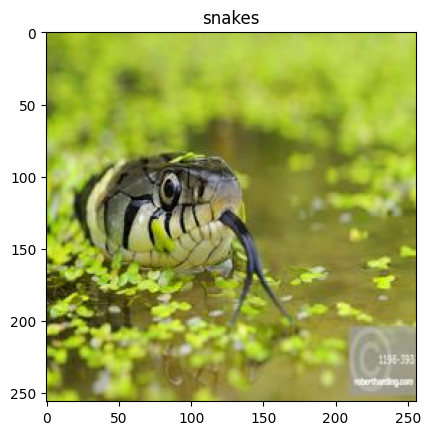

In [10]:
view_random_image(df, "image_path", "label")

In [11]:
def random_image_size(data_frame: pd.DataFrame, image_path_column: str) -> tuple[int]:
    """Show size of any random image choosen from the input dataframe

    parameter:
        data_frame: A dataframe with image_path as mandatory column.

    returns:
        tuple: Shape tuple of a random image"""

    random_row = data_frame.sample(1)
    img = mpimg.imread(random_row[image_path_column].tolist()[0])
    return img.shape

In [12]:
random_image_size(df, "image_path")

(256, 256, 3)

In [13]:
CONFIGURATIONS['IMAGE_SIZE'] = (256, 256)

In [14]:
def visualize_images(df: pd.DataFrame, rows: int = 5, cols: int = 4) -> None:
    """
    Visualizes a sample of images from a DataFrame containing image paths and labels.

    Args:
        df (pd.DataFrame): The input DataFrame containing the 'image_path' and 'label' columns.
        rows (int): The number of rows to display in the grid. Default is 5.
        cols (int): The number of columns to display in the grid. Default is 4.

    Returns:
        None: This function displays a plot of images and does not return any value.
    """

    # Determine the number of images to display, limited by the grid size (rows * cols)
    sample_size = min(len(df), rows * cols)

    # Randomly sample the DataFrame to select images for visualization
    df_sample = df.sample(n=sample_size).reset_index(drop=True)

    # Set the figure size for the plot
    plt.figure(figsize=(20, 20))

    # Loop through the sampled DataFrame and display each image
    for i in range(sample_size):
        plt.subplot(rows, cols, i + 1)  # Create a subplot for each image

        # Load and display the image
        image_path = df_sample['image_path'][i]
        image = Image.open(image_path)
        plt.imshow(image)

        # Set the title as the class name (label) of the image
        class_name = df_sample['label'][i]
        plt.title(class_name, color='blue', fontsize=12)

        # Remove axis ticks and labels for a cleaner look
        plt.axis('off')

    # Show the plot with the sampled images
    plt.show()

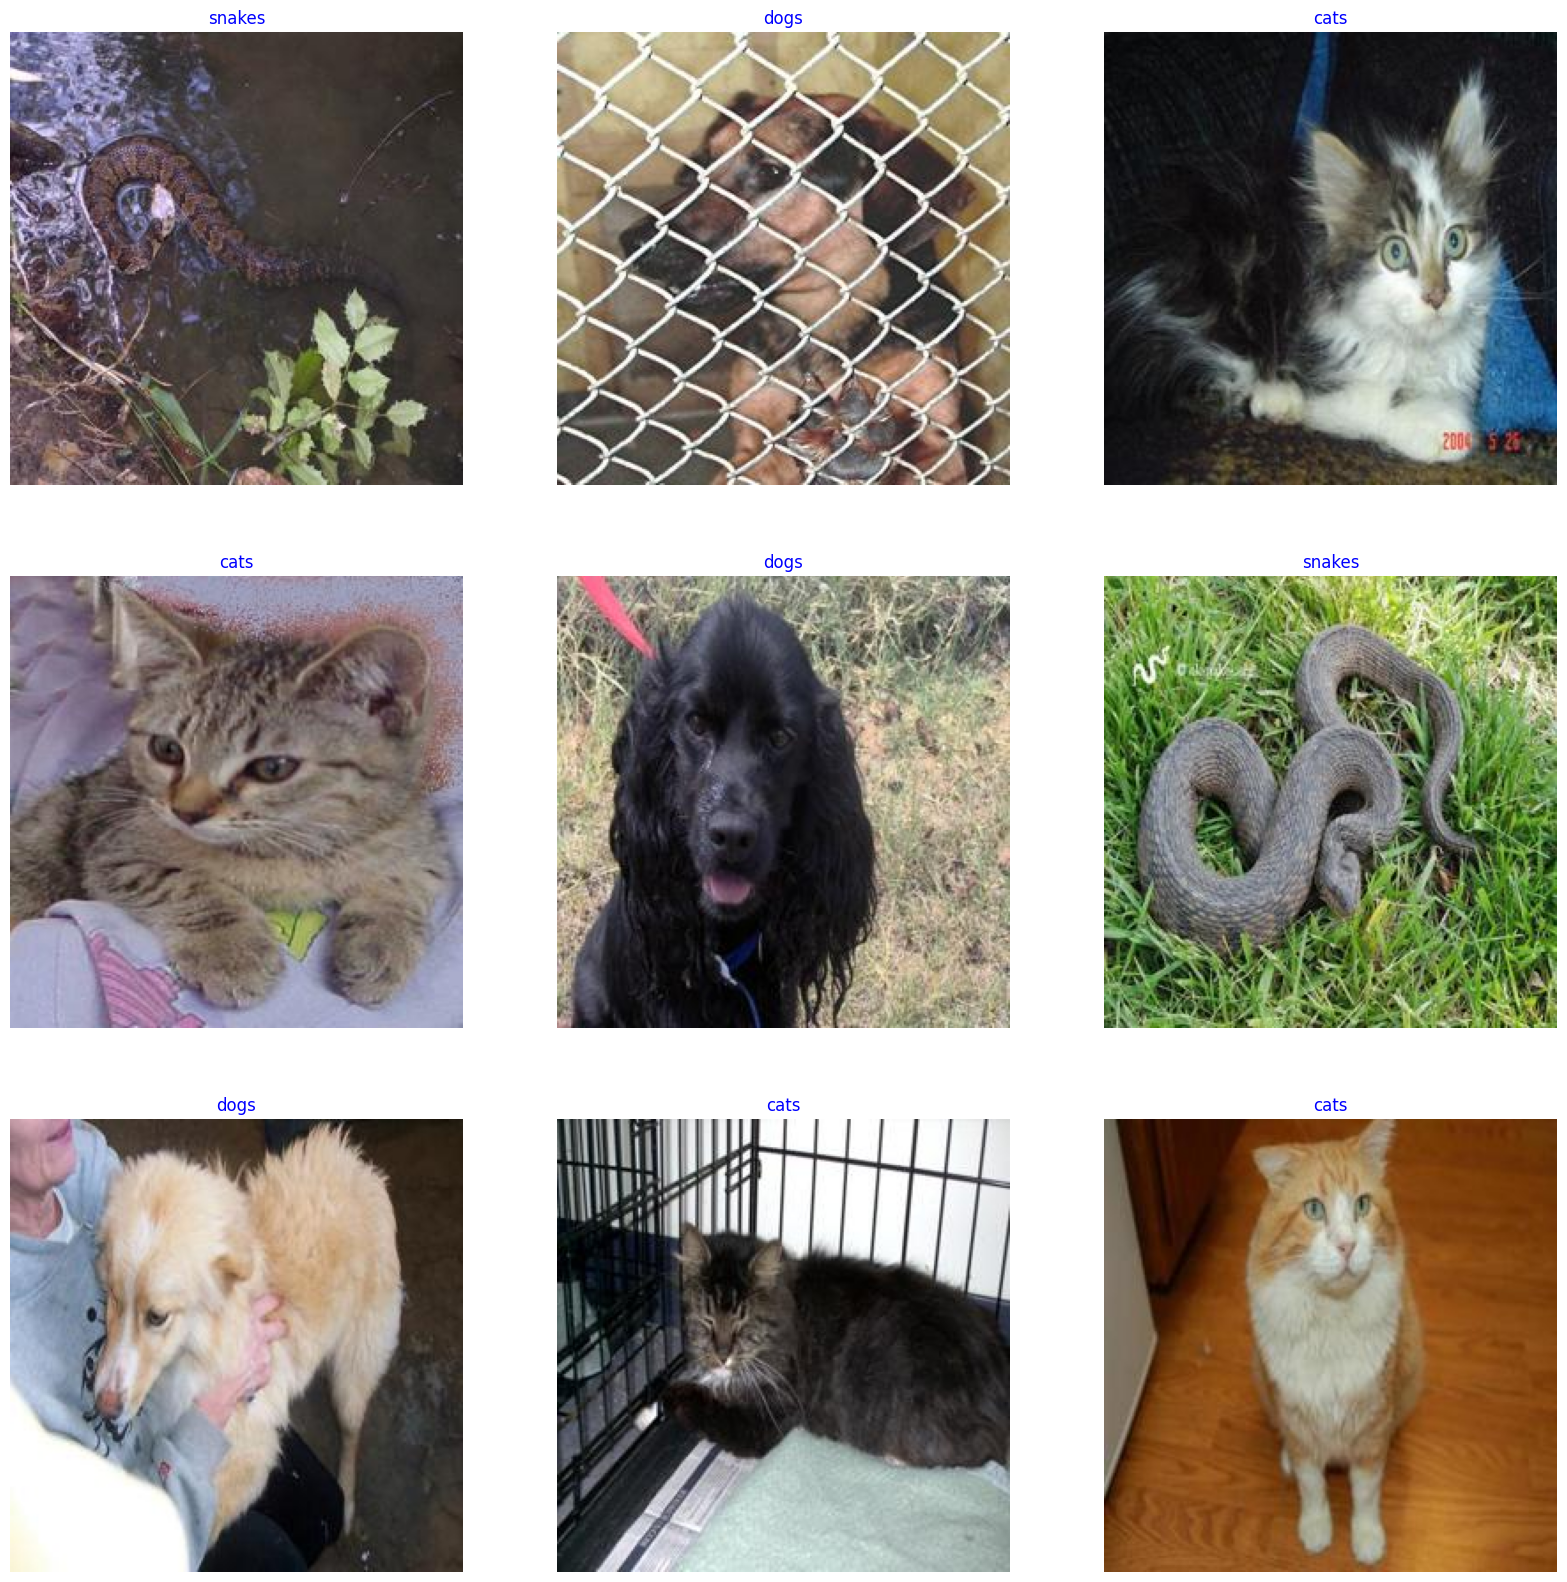

In [15]:
visualize_images(df, 3, 3)

In [16]:
def visualize_class_distribution(dataframe: pd.DataFrame,
                                 save_charts: bool = False,
                                 figure_sizes: tuple = (10, 8),
                                 font_size: int = 12) -> None:
    """
    Visualizes the distribution of images across different classes in a dataset using bar and pie charts.

    Args:
        dataframe (pd.DataFrame): DataFrame containing the dataset with a 'label' column representing class labels.
        save_charts (bool): If True, saves the bar and pie charts as images. Default is False.
        figure_sizes (tuple): Size of the figure for the plots. Default is (10, 8).
        font_size (int): Font size for the text in the plots. Default is 12.

    Returns:
        None: This function displays the plots and optionally saves them as images.
    """

    # Count the number of images per class
    image_counts = dict(dataframe['label'].value_counts())

    # Extracting data for plotting
    classes = list(image_counts.keys())
    counts = list(image_counts.values())

    # Bar Plot: Visualizing the number of images per class
    plt.figure(figsize=figure_sizes)
    bars = plt.bar(classes, counts, color=plt.cm.tab20.colors[:len(classes)])
    plt.xlabel('Classes', fontsize=font_size)
    plt.ylabel('Number of Images', fontsize=font_size)
    plt.title('Number of Images per Class', fontsize=font_size)
    plt.xticks(rotation=45, fontsize=font_size)

    # Adding data labels above each bar
    for bar, count in zip(bars, counts):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 2, str(count), ha='center', fontsize=font_size)

    # Adding gridlines to the y-axis for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Save the bar plot as an image if requested
    if save_charts:
        plt.savefig('bar_plot.png')
    plt.show()

    # Pie Chart: Visualizing the proportion of images per class
    plt.figure(figsize=figure_sizes)
    colors = plt.cm.tab20.colors[:len(classes)]
    plt.pie(counts, labels=classes, autopct='%1.1f%%', startangle=140, colors=colors,
            wedgeprops={'edgecolor': 'black'}, textprops={'fontsize': font_size})
    plt.title('Proportion of Images per Class', fontsize=font_size)
    plt.axis('equal')  # Ensures the pie chart is a circle.

    # Save the pie chart as an image if requested
    if save_charts:
        plt.savefig('pie_chart.png')
    plt.show()

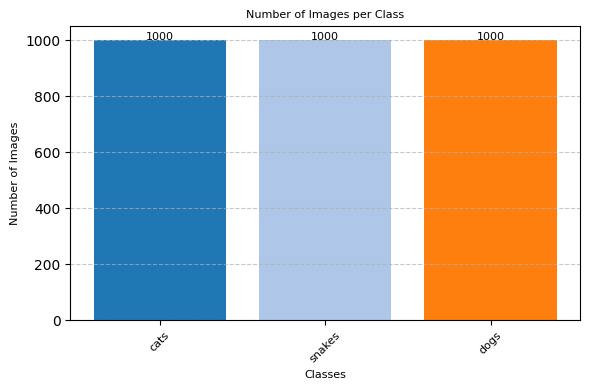

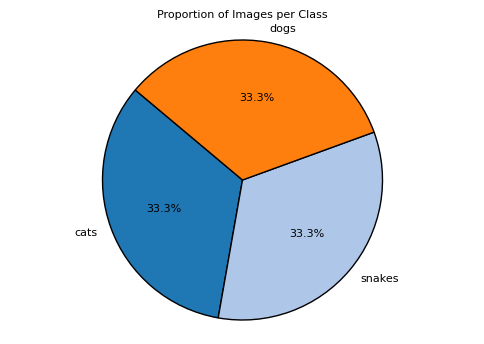

In [17]:
visualize_class_distribution(df, figure_sizes = (6,4), font_size = 8)

# ⚙️ Data Preparation

In [18]:
def df_to_stratified_dfs(
    df: pd.DataFrame,
    trainSize: float,
    validSize: float,
    testSize: float,
    pathColumn: str,
    labelColumn: str
) -> Dict[str, pd.DataFrame]:
    """
    Splits a DataFrame into stratified train, validation, and test sets.

    Args:
        df (pd.DataFrame): The input DataFrame containing data to be split.
        trainSize (float): The proportion of the data to be used for training.
        validSize (float): The proportion of the data to be used for validation.
        testSize (float): The proportion of the data to be used for testing.
        pathColumn (str): The name of the column in the DataFrame that contains the image paths.
        labelColumn (str): The name of the column in the DataFrame that contains the labels.

    Returns:
        Dict[str, pd.DataFrame]: A dictionary containing the resulting DataFrames:
                                 "train_df" (training set),
                                 "valid_df" (validation set, if applicable),
                                 and "test_df" (test set).
    """

    # Extract features (X) and labels (y) from the DataFrame
    X = df[pathColumn]
    y = df[labelColumn]

    # Handle the case where no validation set is desired
    if validSize == 0:
        # Split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=testSize, random_state=42, stratify=y
        )

        # Create DataFrames for training and test sets
        train_df = pd.DataFrame({'image_path': X_train, 'label': y_train}).reset_index(drop=True)
        test_df = pd.DataFrame({'image_path': X_test, 'label': y_test}).reset_index(drop=True)

        # Print sizes of resulting DataFrames
        print("train_df size:", train_df.shape)
        print("test_df size:", test_df.shape)

        # Return dictionary with training and test DataFrames
        return {"train_df": train_df, "test_df": test_df}

    else:
        # Calculate the adjusted validation size based on the remaining data after test split
        tempValidSize = validSize / (1 - testSize)

        # Split the data into remaining (train + valid) and test sets
        X_remaining, X_test, y_remaining, y_test = train_test_split(
            X, y, test_size=testSize, random_state=42, stratify=y
        )

        # Further split the remaining data into training and validation sets
        X_train, X_valid, y_train, y_valid = train_test_split(
            X_remaining, y_remaining, test_size=tempValidSize, random_state=42, stratify=y_remaining
        )

        # Create DataFrames for training, validation, and test sets
        train_df = pd.DataFrame({'image_path': X_train, 'label': y_train}).reset_index(drop=True)
        valid_df = pd.DataFrame({'image_path': X_valid, 'label': y_valid}).reset_index(drop=True)
        test_df = pd.DataFrame({'image_path': X_test, 'label': y_test}).reset_index(drop=True)

        # Print sizes of resulting DataFrames
        print("train_df size:", train_df.shape)
        print("valid_df size:", valid_df.shape)
        print("test_df size:", test_df.shape)

        # Return dictionary with training, validation, and test DataFrames
        return {"train_df": train_df, "test_df": test_df, "valid_df": valid_df}

In [19]:
sdfs = df_to_stratified_dfs(df = df,
    trainSize = .7,
    validSize = .2,
    testSize = .1,
    pathColumn = "image_path",
    labelColumn = "label")

train_df size: (2100, 2)
valid_df size: (600, 2)
test_df size: (300, 2)


In [20]:
train_df = sdfs['train_df']
test_df = sdfs['test_df']
valid_df = sdfs['valid_df']

In [21]:
def dataframes_to_generators(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    valid_df: pd.DataFrame,
    image_size: tuple[int, int],
    batch_size: int,
    input_col: str,
    output_col: str,
) -> dict[str, ImageDataGenerator]:
    """
    This function generates image data generators for training, validation, and testing datasets.
    It applies data augmentation techniques to the training dataset.

    Parameters:
    train_df (DataFrame): DataFrame containing training data
    test_df (DataFrame): DataFrame containing testing data
    valid_df (DataFrame): DataFrame containing validation data
    image_size (tuple): Tuple representing the size of the input images (height, width)
    batch_size (int): Integer representing the batch size for data generators
    input_col (str): String representing the column name in the dataframe containing image paths
    output_col (str): String representing the column name in the dataframe containing labels

    Returns:
    dict: A dictionary containing the generators for training, validation, and testing data
    """

    # Initialize data generators for training, validation, and testing datasets
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
    )

    valid_datagen = ImageDataGenerator(rescale=1.0 / 255)
    test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    # Generate training data
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col=input_col,
        y_col=output_col,
        target_size=image_size,
        class_mode="categorical",
        batch_size=batch_size,
        shuffle=True,
    )

    # Generate validation data
    valid_generator = valid_datagen.flow_from_dataframe(
        dataframe=valid_df,
        x_col=input_col,
        y_col=output_col,
        target_size=image_size,
        class_mode="categorical",
        batch_size=batch_size,
        shuffle=False,
    )

    # Generate testing data
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col=input_col,
        y_col=output_col,
        target_size=image_size,
        class_mode="categorical",
        batch_size=batch_size,
        shuffle=False,
    )

    # Return the generators as a dictionary
    return {
        "train_generator": train_generator,
        "valid_generator": valid_generator,
        "test_generator": test_generator,
    }

In [22]:
gens = dataframes_to_generators(
    train_df = train_df,
    test_df = test_df,
    valid_df = valid_df,
    image_size = CONFIGURATIONS['IMAGE_SIZE'],
    batch_size = CONFIGURATIONS['BATCH_SIZE'],
    input_col = "image_path",
    output_col = "label"
)

Found 2100 validated image filenames belonging to 3 classes.
Found 600 validated image filenames belonging to 3 classes.
Found 300 validated image filenames belonging to 3 classes.


In [23]:
train_generator = gens['train_generator']

valid_generator = gens['valid_generator']

test_generator = gens['test_generator']

In [24]:
# Seeing all the constants used so far
pp.pprint(CONFIGURATIONS)

{'BATCH_SIZE': 32,
 'DATASET': '/kaggle/input/animal-image-classification-dataset/Animals',
 'IMAGE_SIZE': (256, 256),
 'LABELS': {0: 'snakes', 1: 'dogs', 2: 'cats'},
 'NUM_OF_CLASSES': 3}


# ⚙️ Modeling

In [25]:
def mobilenet_model(IMAGE_SIZE: tuple, NUM_OF_CLASSES: int) -> tf.keras.models.Model:
    """
    This function creates a basic MobileNet model for image classification.
    The model is pre-trained on the ImageNet dataset & fine-tuned
    The model is compiled with Adam optimizer, categorical
    crossentropy loss, & accuracy metric.

    Args:
    - IMAGE_SIZE: A tuple representing the size of input images (height, width).
    - NUM_OF_CLASSES: An integer representing the number
                      of classes for classification.

    Returns:
    - A compiled Keras Model object.
    """

    # Load the MobileNet model with pre-trained weights
    base_model = MobileNet(
        weights="imagenet",
        include_top=False,
        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    )

    # Add new classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation="relu")(x)
    predictions = Dense(NUM_OF_CLASSES, activation="softmax")(x)

    # Create a new model with the base model and new layers
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model layers (do not train them)
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model

In [26]:
model = mobilenet_model(IMAGE_SIZE = CONFIGURATIONS['IMAGE_SIZE'], NUM_OF_CLASSES = CONFIGURATIONS['NUM_OF_CLASSES'])

<ipython-input-25-bfa73dddcb86>:18: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [27]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // CONFIGURATIONS['BATCH_SIZE'],
    epochs = 10,
    validation_data = valid_generator,
    validation_steps = valid_generator.samples // CONFIGURATIONS['BATCH_SIZE']
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.7935 - loss: 0.5542 - val_accuracy: 0.9653 - val_loss: 0.0726
Epoch 2/10
 1/65 ━━━━━━━━━━━━━━━━━━━━ 1:34 1s/step - accuracy: 0.9688 - loss: 0.1134

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 613ms/step - accuracy: 0.9688 - loss: 0.1134 - val_accuracy: 0.9705 - val_loss: 0.0620
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.9830 - loss: 0.0513 - val_accuracy: 0.9809 - val_loss: 0.0426
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 43s 657ms/step - accuracy: 0.9688 - loss: 0.0534 - val_accuracy: 0.9809 - val_loss: 0.0422
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.9813 - loss: 0.0430 - val_accuracy: 0.9896 - val_loss: 0.0320
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 34s 503ms/step - accuracy: 1.0000 - loss: 0.0160 - val_accuracy: 0.9896 - val_loss: 0.0329
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.9872 - loss: 0.0389 - val_accuracy: 0.9896 - val_loss: 0.0311
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 33s 484ms/step - accuracy: 0.9688 - loss: 0.0441 - val_accuracy: 0.9896 - val_loss: 0.0294
Epoch 9/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.9887 - loss: 0.0325 - val_accuracy: 0.9809 - val_

# ⚙️ Evaluation

In [28]:
def plot_loss_curves(history) -> None:
    """
    Returns separate loss curves for training and validation metrics.

    Args:
    history: TensorFlow model History object
    """

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

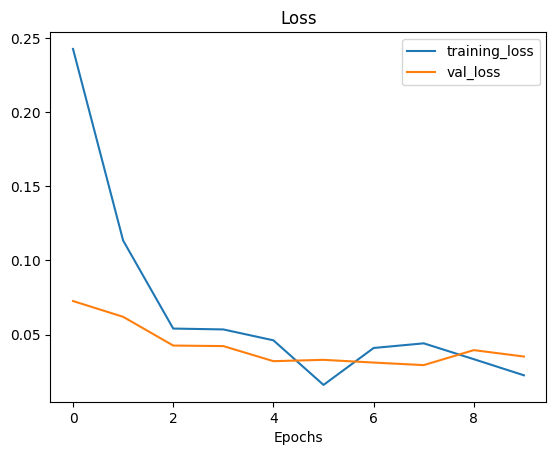

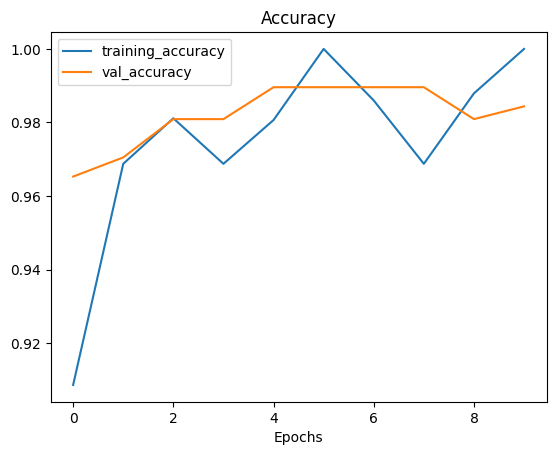

In [29]:
plot_loss_curves(history)

In [30]:
def model_and_test_generators_to_results(
    model: object,
    test_generator: object,
    LABELS: dict[int, str],
    figsize: tuple = (10, 8),
) -> dict[str, Any]:

    """
    Evaluate a model on a test generator and return the results.

    Args:
        model (object): The model to evaluate.
        test_generator (object): The test generator.
        LABELS (dict): A dictionary mapping label indices to label names.
        figsize (tuple, optional): The figure size for the heatmap. Defaults to (10, 8).

    Returns:
        dict: A dictionary containing the results, confusion matrix, accuracy, and heatmap.
    """

    # Get the filenames from the test generator
    filenames = test_generator.filenames
    if not os.path.isabs(filenames[0]):
        # If the filenames are not absolute, prepend the directory
        filenames = [test_generator.directory + '/' + filename for filename in test_generator.filenames]

    # Make predictions on the test generator
    predictions = model.predict(test_generator)
    results = list(zip(filenames, predictions))
    submitList = []

    # Get the ground truth labels
    ground = []
    for i in range(len(test_generator)):
        batch_x, batch_y = test_generator[i]
        for j in range(len(batch_x)):
            label = batch_y[j]
            ground.append(np.argmax(label))

    # Create a list of dictionaries containing the results
    for filename, prediction in results:
        tempd = {}
        tempd['image_path'] = filename
        tempd['image_name'] = filename.split("/")[-1]
        tempd['prediction'] = np.argmax(prediction)
        submitList.append(tempd)

    # Create a pandas DataFrame from the results
    submit = pd.DataFrame(submitList)
    submit['ground'] = ground
    submit['prediction_label'] = submit['prediction'].apply(lambda x: LABELS[x])
    submit['ground_label'] = submit['ground'].apply(lambda x: LABELS[x])
    submit = submit[['image_path', 'image_name', 'ground', 'prediction', 'ground_label', 'prediction_label']]

    # Calculate the confusion matrix
    confusion_matrix = metrics.confusion_matrix(submit.ground, submit.prediction)

    # Create a heatmap of the confusion matrix
    fig, ax = plt.subplots(figsize=figsize)
    sns.set(font_scale=1.2)  # Adjust font size
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=LABELS.values(), yticklabels=LABELS.values(), ax=ax)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Confusion Matrix')

    # Return the results, confusion matrix, accuracy, and heatmap
    return {
        "results": submit,
        "confusion_matrix": confusion_matrix,
        "accuracy": np.trace(confusion_matrix) / np.sum(confusion_matrix),
        "heatmap": fig,
    }

10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step


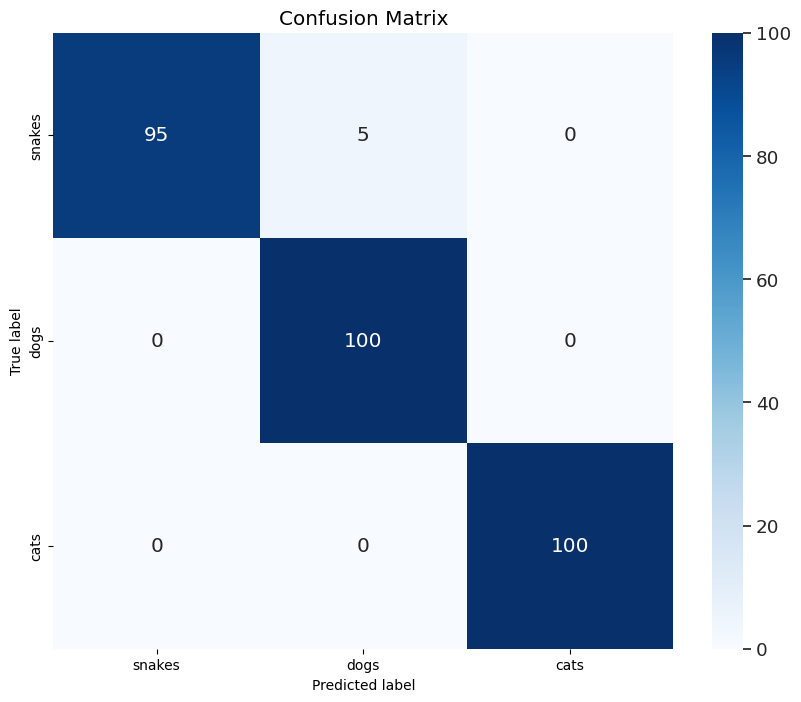

In [31]:
res = model_and_test_generators_to_results(model, test_generator, CONFIGURATIONS['LABELS'] , figsize=(10, 8))

In [32]:
print(f"Accuracy: {res['accuracy']:.2f}")

Accuracy: 0.98


In [33]:
model.save('mobilenet_animal_classification.h5')